In [13]:
from functools import partial

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

In [20]:
import wlcsim.analytical.homolog as whom

In [274]:
def map_not_none(f, iterable, **kwargs):
    return [x for x in map(partial(f, **kwargs), iterable) if x is not None]

In [181]:
L = 100
b = 3  # max plateau is "farthest linear" Ndel=2*L => 4*b**2*L
mu = 5
num_cells = 1000000
label_loc = (1/3) * L
nuc_radius = 3500  # whatever man, a little less than max plateau

In [182]:
cells = [whom.generate_poisson_homologs(mu=mu, chr_size=L) for i in range(num_cells)]

In [183]:
def get_neighbors(linkages, label_loc):
    i = np.searchsorted(linkages, label_loc)
    neighbors = [None, None]
    if i > 0:
        neighbors[0] = linkages[i - 1]
    if i < len(linkages):
        neighbors[1] = linkages[i]
    return neighbors

In [275]:
neighbors = map_not_none(get_neighbors, cells, label_loc=label_loc)

In [268]:
def is_linkless(neighbors):
    return neighbors[0] is None and neighbors[1] is None
def is_linear(neighbors):
    # xor
    return (neighbors[0] is None) != (neighbors[1] is None)
def is_ring(neighbors):
    return neighbors[0] is not None and neighbors[1] is not None

def P_is_empty(mu):
    return np.exp(-mu)

def P_is_ring(mu, l0, L):
    return (1 - np.exp(-(mu/L)*label_loc)) * (1 - np.exp(-(mu/L)*(L - label_loc)))

def P_is_linear(mu, l0, L):
    return 1 - P_is_ring(mu, l0, L) - P_is_empty(mu)
                                              

In [256]:
frac_empty = np.mean([*map(has_no_link, neighbors)])
frac_linear = np.mean([*map(is_linear, neighbors)])
frac_ring = np.mean([*map(is_ring, neighbors)])

In [257]:
f"frac_empty is: {frac_empty} ~ {scipy.stats.poisson.pmf(0, mu)} ~ {P_is_empty(mu)}"

'frac_empty is: 0.006838 ~ 0.006737946999085467 ~ 0.006737946999085467'

In [258]:
f"frac_ring is: {frac_ring} ~ {P_is_ring(mu, label_loc, L)}"

'frac_ring is: 0.781864 ~ 0.7821883508142712'

In [259]:
f"frac_linear ({frac_linear}) is what's left: {P_is_linear(mu, label_loc, L)}"

"frac_linear (0.211298) is what's left: 0.21107370218664334"

In [277]:
def get_N(neighbors, L):
    if is_linkless(neighbors):
        return None
    neighbors = neighbors.copy()
    if neighbors[0] is None:
        neighbors[0] = 0
    if neighbors[1] is None:
        neighbors[1] = L
    return 2*(neighbors[1] - neighbors[0])


def get_N_ring(neighbors):
    if not is_ring(neighbors):
        return None
    return 2*(neighbors[1] - neighbors[0])


def get_N_linear(neighbors, L):
    if not is_linear(neighbors):
        return None
    return get_N(neighbors, L)

In [283]:
Ns = map_not_none(get_N, neighbors, L=L)
Ns_ring = map_not_none(get_N_ring, neighbors)
Ns_linear = map_not_none(get_N_linear, neighbors, L=L)

Analytically, we can .... type this up later....

In [320]:
def P_N_linear(N, mu, l0, L):
    N = np.array(N)
    lam = mu/L
    has_left_only = (1 - np.exp(-lam*l0)) * np.exp(-lam*(L - l0))
    has_right_only = (1 - np.exp(-lam*(L - l0))) * np.exp(-lam*l0)
    Z_L = (1 - np.exp(-lam*l0)) / lam
    Z_R = (1 - np.exp(-lam*(L - l0))) / lam
    return np.zeros_like(N) + (1/2) * (N <= 2*L) * (  # (1/2)* from jacobian
        (N >= 2*(L - l0)) * has_left_only * (1/Z_L)*np.exp(-lam*(N/2 - (L - l0)))
      + (N >= 2*l0) * has_right_only * (1/Z_R)*np.exp(-lam*(N/2 - l0))
    ) / (has_left_only + has_right_only)

def _inside_interval_weights(N, l0, L):
    line_lengths = (
        (L >= N/2)*(N/2 >= L - l0) * (L - N/2)
      + (L - l0 > N/2)*(N/2 >= l0) * l0
      + (l0 > N/2)*(N/2 >= 0) * N/2
    )
#     total_line_length = np.sqrt(2) * l0 * (L + l0)
    return (0 <= N/2) * (N/2 <= L) * line_lengths
    
def P_N_ring(N, mu, l0, L):
    N = np.array(N)
    lam = mu/L
    Z_LR = (np.exp(lam*L) - np.exp(lam*l0))*(np.exp(lam*l0) - 1) \
         / (lam**2 * np.exp(lam*(L + l0)))
    return np.zeros_like(N) + (1/2) * (N <= 2*L) *(
        (1/Z_LR)*np.exp(-lam*N/2) * _inside_interval_weights(N, l0, L)
    )

def P_N(N, mu, l0, L):
    

In [ ]:
bins = np.arange(0, 2*L + 1, 2)
density, bins, _ = plt.hist(Ns, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

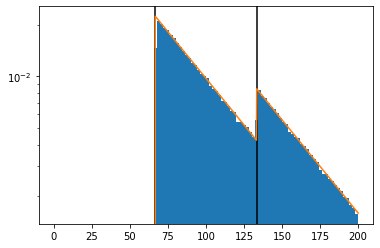

In [302]:
_, _, _ = plt.hist(Ns_linear, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

N = np.linspace(0, 2*L, 1000)
plt.plot(N, P_N_linear(N, mu, label_loc, L))

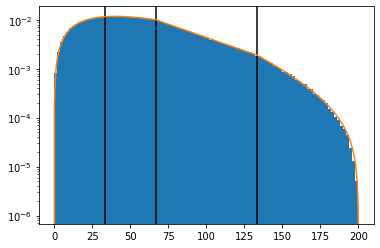

In [321]:
_, _, _ = plt.hist(Ns_ring, density=1, bins=bins)
plt.axvline(2*label_loc, c='k')
plt.axvline(2*label_loc/2, c='k')
plt.axvline(2*(L - label_loc), c='k')
plt.yscale('log')

N = np.linspace(0, 2*L, 1000)
plt.plot(N, P_N_ring(N, mu, label_loc, L))

In [271]:
def get_Ndel(neighbors, label_loc):
    if neighbors[0] is not None:
        return label_loc - neighbors[0]
    elif neighbors[1] is not None:
        return neighbors[1] - label_loc
    else:
        return None
    
def get_Ndel_ring(neighbors, label_loc):
    if not is_ring(neighbors):
        return None
    return label_loc - neighbors[0]

def get_Ndel_linear(neighbors, label_loc):
    if not is_linear(neighbors):
        return None
    if neighbors[0] is not None:
        return label_loc - neighbors[0]
    return neighbors[1] - label_loc


In [279]:
Ndels = map_not_none(get_Ndel, neighbors, label_loc=label_loc)
Ndels_ring = map_not_none(get_Ndel_ring, neighbors, label_loc=label_loc)
Ndels_linear = map_not_none(get_Ndel_linear, neighbors, label_loc=label_loc)

Analytically, this is the 

$$ P(\text{has left neighbor}) P(\Delta_\text{left} = x | \text{has left neighbor}) 
+ P(\text{no left neighbor}) P(\Delta_\text{right} = x | \text{no left neighbor}) $$

where $ P(\Delta_\text{left} = x) = 0$ for $x > l_0$ and $P(\Delta_\text{right} = x) = 0$ for $x > L - l_0$.

In [266]:
def P_Ndel_ring(Ndel, mu, l0, L):
    Ndel = np.array(Ndel)
    lam = mu/L
    # if ring, then it has left-side neighbor
    Z_L = (1 - np.exp(-lam*l0)) / lam
    return np.zeros_like(Ndel) + (Ndel >= 0)*(Ndel <= l0)*(1/Z_L)*np.exp(-lam*Ndel)

def P_Ndel_linear(Ndel, mu, l0, L):
    Ndel = np.array(Ndel)
    lam = mu/L
    has_left_only = (1 - np.exp(-lam*l0)) * np.exp(-lam*(L - l0))
    has_right_only = (1 - np.exp(-lam*(L - l0))) * np.exp(-lam*l0)
    Z_L = (1 - np.exp(-lam*l0)) / lam
    Z_R = (1 - np.exp(-lam*(L - l0))) / lam
    return np.zeros_like(Ndel) + (Ndel >= 0)*(
        (Ndel <= l0) * has_left_only * (1/Z_L)*np.exp(-lam*Ndel)
      + (Ndel <= L - l0) * has_right_only * (1/Z_R)*np.exp(-lam*Ndel)
    )/(has_left_only + has_right_only)

def P_Ndel(Ndel, mu, l0, L):
    Ndel = np.array(Ndel)
    return P_is_empty(mu)*np.zeros_like(Ndel) \
        + P_is_ring(mu, l0, L)*P_Ndel_ring(Ndel, mu, l0, L) \
        + P_is_linear(mu, l0, L)*P_Ndel_linear(Ndel, mu, l0, L)
    
# direct computation. needs to equal sum of split version
def _P_Ndel(Ndel, mu, l0, L):
    Ndel = np.array(Ndel)
    lam = mu/L
    has_left = (1 - np.exp(-lam*l0))
    Z_L = (1 - np.exp(-lam*l0)) / lam
    Z_R = (1 - np.exp(-lam*(L - l0))) / lam
    Ndel_left = (1/Z_L)*np.exp(-lam*Ndel)
    Ndel_right = (1/Z_R)*np.exp(-lam*Ndel)
    return (Ndel >= 0) * (
        (Ndel <= l0) * has_left * Ndel_left 
      + (Ndel <= L - l0) * (1 - has_left) * Ndel_right
    )

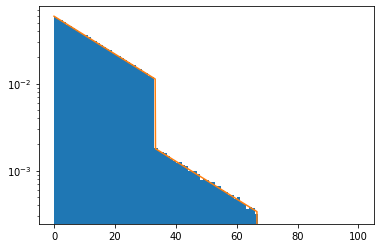

In [267]:
Y, del_bins, _ = plt.hist(Ndels, bins=np.arange(L+1), density=1)
plt.yscale('log')

x = np.linspace(0, L, 1000)
plt.plot(x, P_Ndel(x, mu, label_loc, L))